# https://github.com/modflowpy/flopy

https://flopy.readthedocs.io/en/3.3.5/

https://github.com/DLR-SC/repository-synergy/blob/9e2d3a3da7198c7d23aaff220b0a53fe662cdebc/data/readme_files/modflowpy.flopy.md

# 基于mf2005的非稳定流模型

https://zhuanlan.zhihu.com/p/427533365

In [3]:
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# MODFLOW
mymodel = flopy.modflow.Modflow('mf2005input', exe_name='/usr/local/lib/modflow/mf2005', model_ws = 'mf2005input')
# DIS
Lx = 750.0                             # x 长度
Ly = 1000.0                            # y 长度 
ztop = 5.0                             # z 顶部高程
zbot = -50.0                           # z 底部高程
nlay = 1                               # 含水层层数
nrow = 20                              # 行数
ncol = 15                              # 列数
delc = Lx/ncol                           # x 步长
delr = Ly/nrow                           # y 步长
botm = np.linspace(ztop, zbot, nlay + 1) # z 每一层的底部高程
nper = 3
steady = [True, False, False]
perlen = [1, 100, 100]
nstp = [1, 100, 100]
dis = flopy.modflow.ModflowDis(mymodel, nlay, nrow, ncol, delr = delr,
                               delc = delc, top = ztop, botm = botm[1:], 
                               nper = nper, perlen = perlen, nstp = nstp, steady = steady)
# BAS
ibound = np.ones((nlay, nrow, ncol), dtype = np.int32)
strt = 10.0 * np.ones((nlay, nrow, ncol), dtype = np.float32)
bas = flopy.modflow.ModflowBas(mymodel, ibound = ibound, strt = strt)
# LPF
laytyp = 1   # 含水层类型
vka = 1.0    # 垂直渗透系数，单位：m/d
hk = np.ones((nlay, nrow, ncol), dtype=np.float32)  # 水平渗透系数，单位：m/d
hk[:, 0:11, 0:8]  = 1.0
hk[:, 0:13, 8:16] = 3.0
hk[:, 11:21,0:8]  = 5.0
hk[:, 13:21,8:16] = 5.0
sy = 0.1     # 给水度，单位：1/m
ss = 1.e-4   # 单位储水量，单位：1/m
lpf = flopy.modflow.ModflowLpf(model = mymodel, hk = hk, vka = vka, sy = sy,
                               ss = ss, laytyp = laytyp, ipakcb = 1)
# CHD
# 应力周期 0
shead_0 = 3
ehead_0 = 3
bound_sp_0 = []     
# 应力周期 1
shead_1 = 3
ehead_1 = 6
bound_sp_1 = []
# 应力周期 2
shead_2 = 6
ehead_2 = 1
bound_sp_2 = []
for lay in range(nlay):
    for col in range(ncol):
        bound_sp_0.append([lay, 0, col, shead_0, shead_0])
        bound_sp_1.append([lay, 0, col, shead_1, ehead_1])
        bound_sp_2.append([lay, 0, col, shead_2, ehead_2])

chd_spd = {0: bound_sp_0, 1: bound_sp_1, 2: bound_sp_2}
chd = flopy.modflow.ModflowChd(model= mymodel, stress_period_data = chd_spd)
# WEL
wel_spd = {0: [[0, 3, 3, -500], [0, 5, 11, -100], [0, 18, 5,  600]],
           1: [[0, 3, 3, -200], [0, 5, 11,  200], [0, 18, 5, -350]],
           2: [[0, 3, 3, -100], [0, 5, 11,  500], [0, 18, 5,  100]]}
wel = flopy.modflow.ModflowWel(mymodel, stress_period_data = wel_spd)
# RIV
k_rivbott = 1 # 河床底部渗透系数，m/d
thick_rivbott = 1 # 河床沉积物厚度，m
cond = k_rivbott * (delr) * (delc) / (thick_rivbott) # conductance, m2/d
r_bott = 0 # 河底高程
riv_stage = [1, 5, 2] # 河流水位
riv_sp_0 = [] # 应力周期 0
riv_sp_1 = [] # 应力周期 1
riv_sp_2 = [] # 应力周期 2
for i in range(ncol):
    riv_sp_0.append([0, 14, i, riv_stage[0], cond, r_bott])
    riv_sp_1.append([0, 14, i, riv_stage[1], cond, r_bott])
    riv_sp_2.append([0, 14, i, riv_stage[2], cond, r_bott])
riv_spd = {0: riv_sp_0, 1: riv_sp_1, 2: riv_sp_2}
riv = flopy.modflow.ModflowRiv(model = mymodel, stress_period_data = riv_spd)
# OC
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", 
                                            "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(mymodel, stress_period_data = stress_period_data, compact = True)
# PCG
pcg = flopy.modflow.ModflowPcg(model = mymodel)
# RUN
mymodel.write_input()

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005input.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/10/21  9:21:51

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7  

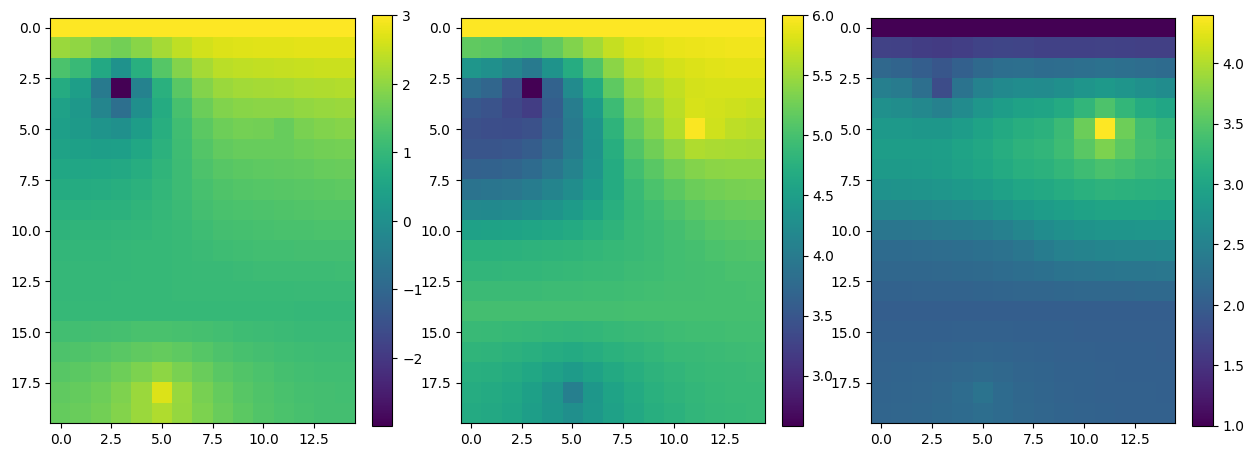

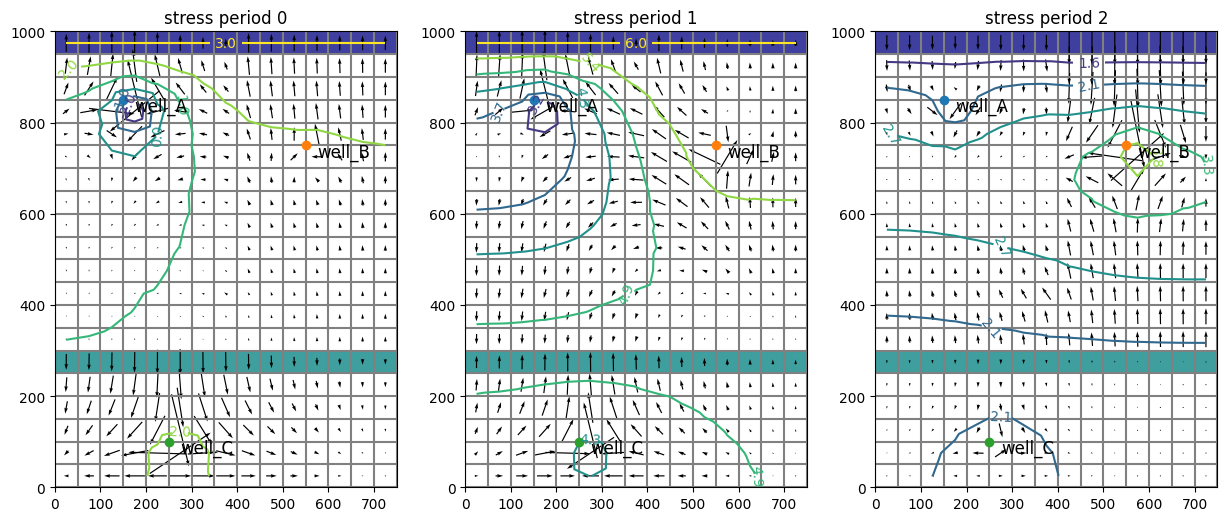

In [4]:

success, mfoutput = mymodel.run_model(pause = False, report = True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

headobj = flopy.utils.binaryfile.HeadFile('./mf2005input/mf2005input' + ".hds")
budgobj = flopy.utils.binaryfile.CellBudgetFile('./mf2005input/mf2005input' + ".cbc")
times = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]]
head = {}
frf = {}
fff = {}
for stress_per, time in enumerate(times):
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time)
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time)
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time)
#########
# head
fig = plt.figure(figsize=(15, 45))
ax0 = fig.add_subplot(1, 3, 1)
im0 = ax0.imshow(head['sp0'][0])
plt.colorbar(im0, fraction = 0.06, pad = 0.05)
ax1 = fig.add_subplot(1, 3, 2)
im1 = ax1.imshow(head['sp1'][0])
plt.colorbar(im1, fraction = 0.06, pad = 0.05)
ax2 = fig.add_subplot(1, 3, 3)
im2 = ax2.imshow(head['sp2'][0])
plt.colorbar(im2, fraction = 0.06, pad = 0.05)
#########
# fd
fig = plt.figure(figsize = (15, 45))
mytimes = [perlen[0], perlen[0] + perlen[1], perlen[0] + perlen[1] + perlen[2]]
for iplot, time in enumerate(mytimes):
    head = headobj.get_data(totim = time)
    frf = budgobj.get_data(text = "FLOW RIGHT FACE", totim = time)[0]
    fff = budgobj.get_data(text = "FLOW FRONT FACE", totim = time)[0]
    
    ax = fig.add_subplot(1, len(mytimes), iplot + 1, aspect = "equal")
    ax.set_title("stress period " + str(iplot))
    
    pmv = flopy.plot.PlotMapView(model = mymodel, layer = 0, ax = ax)
    qm = pmv.plot_ibound()
    lc = pmv.plot_grid() # grid
    qm = pmv.plot_bc("CHD", alpha = 0.5)
    riv = pmv.plot_bc("RIV", alpha = 0.5)
    
    if head.min() != head.max():
        cs = pmv.contour_array(head)
        plt.clabel(cs, inline = 1, fontsize = 10, fmt = "%1.1f")
        quiver = pmv.plot_vector(frf, fff)
    # well  
    wpt0 = (150.0, 850.0)
    wpt1 = (550.0, 750.0)
    wpt2 = (250.0, 100.0)
    mfc = "None"
    if (iplot + 1) == len(mytimes):
        mfc = "black"
    ax.plot(wpt0[0], wpt0[1], lw = 0, marker="o")
    ax.text(wpt0[0] + 25, wpt0[1] - 25, "well_A", size=12, zorder=12)
    ax.plot(wpt1[0], wpt1[1], lw = 0, marker="o")
    ax.text(wpt1[0] + 25, wpt1[1] - 25, "well_B", size=12, zorder=12)
    ax.plot(wpt2[0], wpt2[1], lw = 0, marker="o")
    ax.text(wpt2[0] + 25, wpt2[1] - 25, "well_C", size=12, zorder=12)

# 基于MT3DMS的溶质运移模型

https://zhuanlan.zhihu.com/p/429847479

本次模型，我们选择 GMS 10.5 Tutorial 的 MT3DMS Grid Approach。该模型也是 MT3D manual P152 的内容（有修改）。

研究区被离散化为 32 列，40 行，每个单元格均为 50m × 50m，高程为 10m，厚度为 10m 的承压含水层。

模型东西两侧无流量。南北均是指定水头边界，其中北部水头值为 250m，南部水头值为 36.25m。

研究区共有两口井，井 A (9, 15) 往地下水中注入指定浓度 (57.87 ppm) 的水体，注水速率为 0.001m3/s (折合: 86.4m3/d)；另有井 B (23, 15) 进行抽水，抽水速率为 -0.0189m3/s (折合: 1632.96m3/d)。

在两口井的中间，存在一个渗透性较低的区域（见下图），渗透系数较其他区域 (1.474 × 10^(-4))m/s (折合: 12.7m/d) 低三个数量级 (1.474 × 10^(-7))m/s (折合: 0.0127m/d)。

研究区孔隙率为 0.3，纵向弥散度为 20m，横向弥散度与纵向弥散度之比为 0.2。

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
# MODFLOW
mf = flopy.modflow.Modflow(modelname = 'mt3dms', exe_name= '/usr/local/lib/modflow/mf2005', model_ws = 'mt3dms')
# DIS
Lx = 1600
Ly = 2000
nrow = 40
ncol = 32
nlay = 1
delr = Lx / ncol
delc = Ly / nrow
ztop = 10
zbot = 0
botm = np.linspace(ztop, zbot, nlay + 1)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr = delr, delc = delc, top = ztop, 
                               botm = botm[1:], perlen = 365, nstp = 30, itmuni = 4)
# BAS
ibound = np.ones((nlay, nrow, ncol), dtype = np.int32)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1
strt = 145 * np.ones((nlay, nrow, ncol), dtype = np.float32)
strt[0, 0, :] = 250
strt[0, -1, :] = 36.25
bas = flopy.modflow.ModflowBas(mf, ibound = ibound, strt = strt)
# LPF
laytyp = 0
hk = np.ones((nlay, nrow, ncol), dtype=np.float32)
hk[:, :, :]  = 12.7
hk[:, 10:18, 4:18]  = 0.0127
lpf = flopy.modflow.ModflowLpf(mf, hk = hk, vka = hk, laytyp = laytyp, ipakcb = 1)
# WEL
wel_spd = {0: [[0, 9, 15, 86.4], [0, 23, 15, -1633.0]]}
wel = flopy.modflow.ModflowWel(mf, stress_period_data = wel_spd)
# OC
oc_spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data = oc_spd, compact = True)
# PCG
pcg = flopy.modflow.ModflowPcg(mf)
# LMT
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')
# write
mf.write_input()

In [6]:

success, mfoutput = mf.run_model(pause = False, report = True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mt3dms.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/10/21  9:22:30

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Gro

Text(0.5, 1.0, 'Flow Direction')

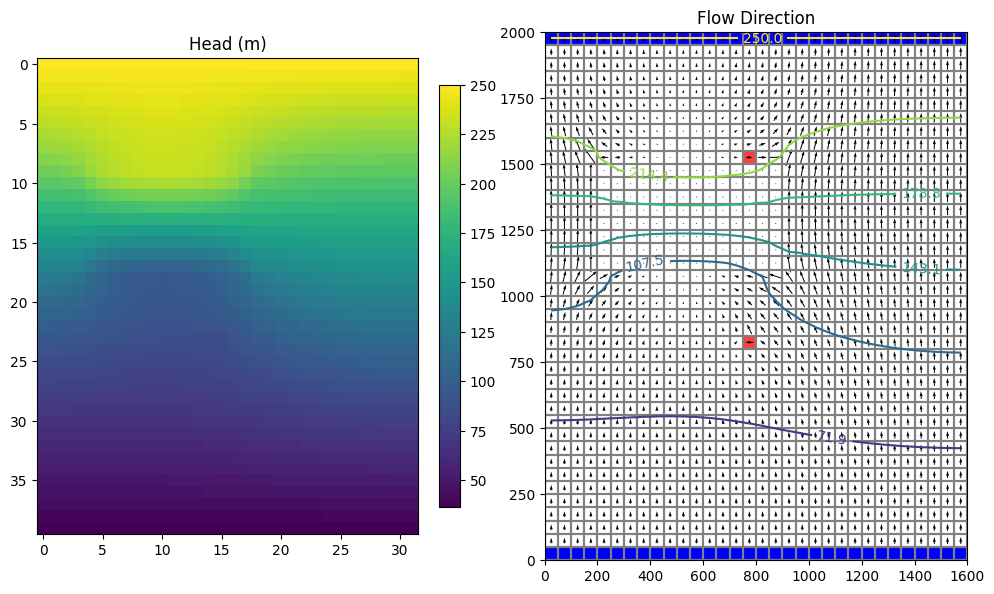

In [7]:
# 在完成上述步骤后，绘制水头和流场结果。

headobj = flopy.utils.binaryfile.HeadFile('./mt3dms/mt3dms' + ".hds")
budgobj = flopy.utils.binaryfile.CellBudgetFile('./mt3dms/mt3dms' + ".cbc")
head = headobj.get_data()[0]
frf = budgobj.get_data(text='FLOW RIGHT FACE')[0]
fff = budgobj.get_data(text='FLOW FRONT FACE')[0]

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(1, 2, 1)
head_p = ax1.imshow(head)
plt.title('Head (m)')
plt.colorbar(head_p, fraction = 0.05, pad = 0.05)

ax2 = fig.add_subplot(1, 2, 2)
modelmap = flopy.plot.PlotMapView(model = mf, layer = 0)
grid = modelmap.plot_grid() 
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
qm = modelmap.plot_bc("WEL", alpha = 0.5)
quiver = modelmap.plot_vector(frf, fff)
cs = modelmap.contour_array(head)
plt.clabel(cs, inline = 1, fmt = "%1.1f")
plt.title('Flow Direction')

In [8]:
# 4 构建溶质运移模型
# 4.1 创建MT3D模型
# modflowmodel 是需要链接的 MODFLOW 模型。将 MT3DMS 模型命名为 mt。
mt = flopy.mt3d.Mt3dms(modelname = 'mt', version = 'mt3dms', 
                       exe_name = '/usr/local/lib/modflow/mt3dms', modflowmodel = mf, model_ws = 'mt3dms')


设置基本运移条件

BTN 用来设置溶质运移的基本条件，参数较多，主要介绍几个常用的参数：

**sconc**：模拟溶质的起始浓度，可以用数组来表示。如果是多溶质的运移，则额外增加 sconc2，sconc3。本次溶质由注入井介入，因此初始浓度为 0。

**prsity**：孔隙率。本次为 0.3。

**tunit、munit**：溶质的时间单位和质量单位。在此仅作标识。在 DIS 中设置的 itmuni 为 4，因此 tunit 保持一致为天。munit 为 ppm。

**icbund**：与 ibound 用法类似，用于说明各点性质。icbund > 0 为活动浓度单元，浓度可以自由变化；icbund = 0 为不活动浓度单元，浓度为 0；icbund < 0 为恒定浓度单元，浓度保持初始浓度不变。

**nprs、timprs**：这两个参数是反映保存不同时刻各点的浓度值。在离散化中，我们设置 perlen 为 365 天，默认只保存最后的浓度结果。nprs 为需要保存的次数，我们将其设为 5，即保存 5 次结果；timprs 为一个浮点数的列表形式，列表中元素的数量必须与 nprs 相同，即表示保存 5 次结果的时刻，本次将其设为 第 1 天，第 21 天，第 61 天，第 121 天和第 361 天。

In [9]:
icbund = np.ones((nlay, nrow, ncol))
btn = flopy.mt3d.Mt3dBtn(mt, sconc = 0, prsity = 0.3, thkmin = 0.01, tunit = 'D', munit = 'ppm',
                         nprs = 5, timprs = [0,20,60,120,360], icbund = icbund)

In [10]:
print(btn)


    Basic Transport Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.mt3dms.mt.Mt3dms`) to which
        this package will be added.
    MFStyleArr : str
        Specifies whether or not to read arrays using the MODFLOW array reader
        format or the original MT3DMS array reader
    DRYCell : str
        Specifies whether or not to route mass through dry cells.  When MF-NWT
        is used to generate the flow-transport link file, this is a distinct
        possibility.
    Legacy99Stor : str
        Specifies whether or not to use the storage formulation used in MT3DMS
    FTLPrint : str
        Specifies if flow-transport link terms (cell-by-cell flows) should be
        echoed to the MT3D-USGS listing file.
    NoWetDryPrint : str
        Specifies whether or not to suppress wet/dry messaging in the MT3D-USGS
        listing file.
    OmitDryBudg : str
        Specifies whether or not to include the mass flux

In [11]:
# 对流和弥散分别是通过 ADV 和 DSP 来控制的。部分重要参数设置如下：

# al：纵向弥散度，根据模型设计要求为 20。
# trpt：横向弥散度与纵向弥散度之比，本次为 0.2。
# trpv：垂直弥散度与纵向弥散度之比，模型设计中未要求，本次设为 0.01。

adv = flopy.mt3d.Mt3dAdv(mt, mixelm = -1, percel = 1)
dsp = flopy.mt3d.Mt3dDsp(mt, al = 20, dmcoef = 0, trpt = 0.2, trpv = 0.01)

In [12]:
# 源汇项
# 源汇项由 SSM 控制。本次的溶质来源于上游的井 A。应力周期由字典控制，井的类型为 2。

ssm_data = {}
ssm_data[0] = [(0, 9, 15, 57.87, 2)]
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data = ssm_data)

In [13]:
# 求解采用 GCG。

gcg = flopy.mt3d.Mt3dGcg(mt, mxiter = 1, iter1 = 50, isolve = 1, cclose = 0.0001)
mt.write_input()
mt.run_model()

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mt3dms
 MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
 Developed at University of Alabama for U.S. Department of Defense

 Using NAME File: mt.nam                                            

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    12.167    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:   2.814     Total Elapsed Time:   2.8135    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.639      [K,I,J]    1   10   16
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1028      [K,I,J]    1   10   17
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8232E-02  [K,I,J]    1   10   18
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8087E-03  [K,I,J]    1   10   19
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1177E-03  [K,I,J]    1   11   19
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.1537E-04  [

(False, [])

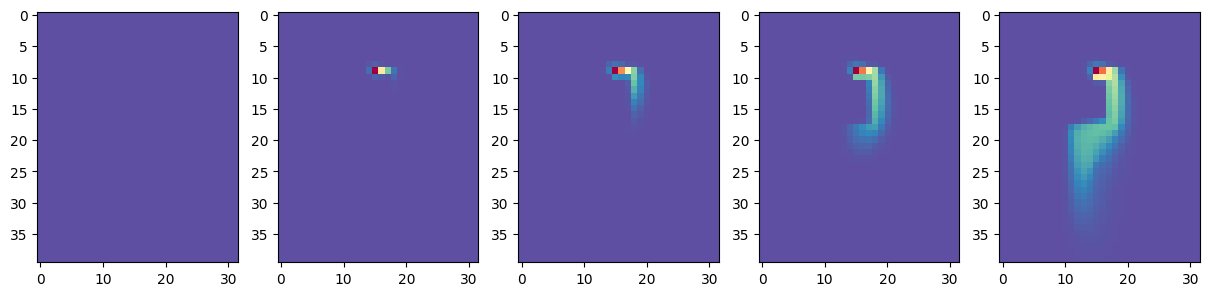

In [15]:
# 模拟的结果保存在 MT3D001.UCN 文件中，因此读取其二进制文件即可作图。

# 由于在上述过程中，共包括了五次结果，分别是第 1，21，61，121 和 361 天的结果，因此分别绘制五次运移结果。

conc = flopy.utils.UcnFile('./mt3dms/MT3D001.UCN')
times = conc.get_times()
conc = conc.get_alldata()

fig = plt.figure(figsize=(15, 60))
ax = [i for i in range(10)]
for i in range(5):
    ax[i] = fig.add_subplot(1, 5, i + 1)
    ax[i].imshow(conc[i,0], cmap='Spectral_r') 

# 基于mf6的溶质运移模型

https://zhuanlan.zhihu.com/p/532012679

In [16]:
# Filename
sim_ws = 'simulation_mf6'
sim_name = 'model'          # 模拟总名称
gwfname = "gwf_" + sim_name # 渗流模型名称
gwtname = "gwt_" + sim_name # 溶质运移模型名称

In [17]:
# Units
length_units = "meters"   # 长度单位
time_units = "days"       # 时间单位

In [18]:
# Discretization
import numpy as np
nper = 1                  # 稳定流，周期数为 1
nlay = 8                  # 层数
nrow = 15                 # 行数
ncol = 21                 # 列数
delr = 10.0               # 单位行长
delc = 10.0               # 单位列长
delz = 10.0               # 单位层高
top = 0.0                 # 顶部高程
botm = [-delz * k for k in range(1, nlay + 1)]     # 底部高程（多层，为列表）
idomain = np.ones((nlay, nrow, ncol), dtype = int) # 参与模拟的区域，1 为参与

print(botm)
print(idomain)

[-10.0, -20.0, -30.0, -40.0, -50.0, -60.0, -70.0, -80.0]
[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]


In [19]:
# 设置溶质运移模型专门参数:
# GWT
porosity = 0.2
al = 10.0                    # 纵向弥散系数
trpt = 0.3; ath1 = al * trpt # 横向弥散系数
trpv = 0.3; atv = al * trpv  # 垂直弥散系数

# 设置渗流模型专门参数:

# GWF
icelltype = 0
k11 = 0.5
k33 = k11


每个单元格的Icelltype(整型)标志，用于指定如何处理饱和厚度。0表示饱和厚度保持不变;>0表示饱和厚度随计算头部变化，当头部低于单元顶部时;<0表示饱和厚度随计算头的变化而变化，除非THICKSTRT选项生效。当THICKSTRT生效时，icelltype的负值表示饱和厚度将作为STRT-BOT计算并保持不变。



---


k33 (double)为第三椭球轴的导水性(如果指定了K33OVERK选项，则为k33 /K的比值);对于未旋转的情况，这是垂直的水力传导率。当应用各向异性时，K33对应于K33张量分量。

所有包含的单元格(IDOMAIN > 0)的K33值必须大于零。

In [21]:
# 时间离散化参数:
# Temporal discretization
perlen = 100.0
nstp = 10
tsmult = 1.0
tdis_ds = []
tdis_ds.append((perlen, nstp, tsmult),)
print(tdis_ds)

# 求解器参数：
# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0

[(100.0, 10, 1.0)]


In [22]:
# 初始条件: # Initial conditions
# Starting concentrations 初始浓度
sconc = 0.0
# Starting Heads 初始水头
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[:, :, 0] = 13.33

print(strt)

[[[13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  ...
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]]

 [[13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  ...
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]]

 [[13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  ...
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]]

 ...

 [[13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  [13.33  0.    0.   ...  0.    0.    0.  ]
  ...
  [13.33  0.    0.   ...  0.    0.    0.

In [23]:
# 边界条件: # Boundary conditions
# wel_spd 井
qwell = 0.5
cwell = 100.0
#               (k, i, j),  flow,  conc
wel_spd = {0: [[(6, 7, 2), qwell, cwell]]}

print(wel_spd)

{0: [[(6, 7, 2), 0.5, 100.0]]}


In [ ]:
# chd_spd 指定水头
chd_spd = []
for k in np.arange(nlay): # 东西两侧分别指定
    for i in np.arange(nrow):
        #               (l, r, c),          head, conc
        chd_spd.append([(k, i, 0), strt[k, i, 0], 0.0])
        chd_spd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
chd_spd = {0: chd_spd}

print(chd_spd)

In [25]:
def build_model():
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/lib/modflow/mf6'
    )

    # 时间离散化
    flopy.mf6.ModflowTdis(
        sim, nper=nper, perioddata=tdis_ds, time_units=time_units
    )

    # GWF
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwfname),
    )

    # 渗流模型求解参数
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwfname),
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # 离散化
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename="{}.dis".format(gwfname),
    )

    # 含水层特性
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename="{}.npf".format(gwfname),
    )
    

    # 初始水头
    flopy.mf6.ModflowGwfic(
        gwf, strt=strt, filename="{}.ic".format(gwfname)
    )

    # 指定水头边界
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chd_spd),
        stress_period_data=chd_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename="{}.chd".format(gwfname),
    )

    # 井边界
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=wel_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename="{}.wel".format(gwfname),
    )

    # 输出控制
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord="{}.hds".format(gwfname),
        budget_filerecord="{}.bud".format(gwfname),
        headprintrecord=[
            ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    # GWT
    gwt = flopy.mf6.ModflowGwt(
        sim,
        modelname=gwtname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwtname),
    )

    # 溶质运移模型求解参数
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwtname),
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # 离散化
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename="{}.dis".format(gwtname),
    )

    # 初始浓度
    flopy.mf6.ModflowGwtic(
        gwt, strt=sconc, filename="{}.ic".format(gwtname)
    )

    # 对流
    flopy.mf6.ModflowGwtadv(
        gwt, scheme="UPSTREAM", filename="{}.adv".format(gwtname)
    )

    # 弥散
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=al,
        ath1=ath1,
        atv=atv,
        filename="{}.dsp".format(gwtname),
    )

    # 化学反应 (等同于 MT3DMS 的 reaction)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename="{}.mst".format(gwtname),
    )

    # 源汇项
    sourcerecarray = [
        ("WEL-1", "AUX", "CONCENTRATION"),
        ("CHD-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(
        gwt, sources=sourcerecarray, filename="{}.ssm".format(gwtname)
    )

    # 输出控制
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord="{}.cbc".format(gwtname),
        concentration_filerecord="{}.ucn".format(gwtname),
        concentrationprintrecord=[
            ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
    )

    # GWF 和 GWT 之间的交换
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename="{}.gwfgwt".format(sim_name),
    )
    return sim, gwf, gwt

In [26]:
sim, gwf, gwt = build_model()

In [27]:
print(sim)

sim_name = model
sim_path = /home/nandahgy/simulation_mf6
exe_name = /usr/local/lib/modflow/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = model


###################
Package model.tdis
###################

package_name = model.tdis
filename = model.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = model


###################
Package ims_-1
###################

package_name = ims_-1
filename = gwf_model.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = model


###################
Package ims_0
###################

package_name = ims_0
filename = gwt_model.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = model


###################
Package model.gwfgwt
###################

package_name = model.gwfgwt
filename = model.gwfgwt
package_type = gwfgwt
model

In [28]:
sim.write_simulation(silent = True)

In [29]:
success, buff = sim.run_simulation(silent = True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

In [30]:
# 运行完毕后，分别读取水头和浓度结果（我们使用 get_alldata 读取了全部时刻的结果）:

head = gwf.oc.output.head().get_alldata()
concentration = gwt.oc.output.concentration().get_alldata()

# 我们可以查看结果的维度:

print(head.shape)

# 10: 时间 - nstp 值。
# (8, 15, 21): 网格空间

(10, 8, 15, 21)


**绘制结果**

建立一个绘图函数:

In [31]:
import matplotlib.pyplot as plt

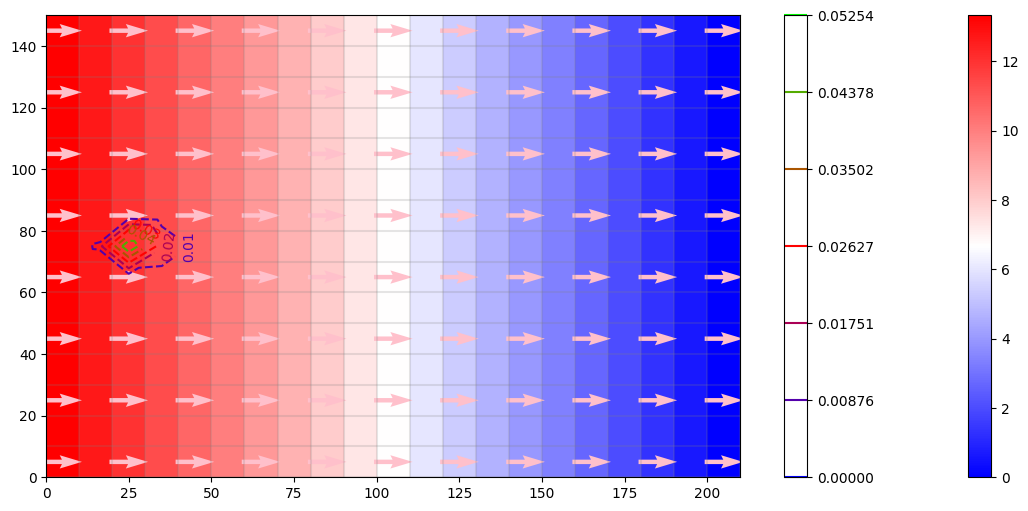

In [32]:
def plot_results(model, result):
    fig = plt.figure(figsize = (14, 6))
    ax = fig.add_subplot(1, 1, 1)
    pmv = flopy.plot.PlotMapView(model = model, ax = ax, layer = 4)
    pmv.plot_grid(ax = ax, color = ".5", alpha = 0.2) # 绘制网格
    
    # 网格填充颜色
    plot_array = pmv.plot_array(head[0,5], cmap = 'bwr')
    plt.colorbar(plot_array)
    
    # 绘制等值线
    plot_contour_array = pmv.contour_array(result, cmap = "brg", linestyles="--")
    plt.clabel(plot_contour_array, fmt = r'%.2f') # 绘制等值线上文本标注
    plt.colorbar(plot_contour_array)              # 等值线图例
    
    pmv.plot_bc(package = gwf.get_package("WEL-1"), color = 'green')
    pmv.plot_inactive(ibound = gwf.modelgrid.idomain, color_noflow = 'black')
    
    # 绘制水流的方向 (粉红色箭头)
    spdis = gwf.oc.output.budget().get_data(text = 'DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    pmv.plot_vector(qx, qy, normalize = True, istep = 2, jstep = 2, color = "pink")
    
plot_results(model = gwf, result = concentration[0,5])

# 查看

In [33]:
!cat /home/nandahgy/mt3dms/mt3dms.list

                                  MODFLOW-2005     
      U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                            VERSION 1.12.00 2/3/2017

 LIST FILE: mt3dms.list
                         UNIT    2

 OPENING mt3dms.dis
 FILE TYPE:DIS   UNIT   11   STATUS:OLD    
 FORMAT:FORMATTED              ACCESS:SEQUENTIAL          

 OPENING mt3dms.bas
 FILE TYPE:BAS6   UNIT   13   STATUS:OLD    
 FORMAT:FORMATTED              ACCESS:SEQUENTIAL          

 OPENING mt3dms.lpf
 FILE TYPE:LPF   UNIT   15   STATUS:OLD    
 FORMAT:FORMATTED              ACCESS:SEQUENTIAL          

 OPENING mt3dms.wel
 FILE TYPE:WEL   UNIT   20   STATUS:OLD    
 FORMAT:FORMATTED              ACCESS:SEQUENTIAL          

 OPENING mt3dms.oc
 FILE TYPE:OC   UNIT   14   STATUS:OLD    
 FORMAT:FORMATTED              ACCESS:SEQUENTIAL          

 OPENING mt3dms.pcg
 FILE TYPE:PCG   UNIT   27   STATUS:OLD    
 FORMAT:FORMATTED              ACCESS:SEQUENTIAL          

 OPENING mt3

# 导出到压缩包

In [34]:
import os
import time as t
import zipfile


def zipDir(dirpath, outFullName):
    """
    压缩指定文件夹
    :param dirpath: 目标文件夹路径
    :param outFullName: 压缩文件保存路径+xxxx.zip
    :return: 无
    """
    zip = zipfile.ZipFile(outFullName, "w", zipfile.ZIP_DEFLATED)  # 创建zip文件

    for path, dirnames, filenames in os.walk(dirpath):  # 遍历文件
        fpath = path.replace(dirpath, "")  # 去掉目标跟路径，只对目标文件夹下边的文件及文件夹进行压缩（即生成相对路径）
        for filename in filenames:
            zip.write(os.path.join(path, filename), os.path.join(fpath, filename))
    zip.close()


zipDir("/home/nandahgy/mt3dms", "/home/nandahgy/output.zip")

# 导出到GIS

In [41]:
def custom_coordinates(a):
    # 获取维度
    cols, rows = a.shape
    # 建立坐标
    x = np.linspace(0, rows - 1, rows)
    y = np.linspace(0, cols - 1, cols)

    mesh = np.meshgrid(x, y)

    x_c = mesh[0].reshape(rows * cols, 1)
    y_c = np.flip(mesh[1]).reshape(rows * cols, 1)
    
    output = np.concatenate((x_c, y_c, a.reshape(rows * cols, 1)), axis = 1)
    # 删除空值
    output = pd.DataFrame(output)
    # 此处是将 -999 (MODFLOW 对无值区域的显示) 转换为 Nan 值，然后删除其所在行
    output = output[~output.isin([-999.0])]
    output.dropna(axis = 0, how = 'any', inplace = True)
    # 导出 csv
    output.to_csv('output.csv', index = False, header = ['X','Y','S'])
    return output

In [39]:
head.shape

(10, 8, 15, 21)

In [42]:
# import flopy
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# hds = flopy.utils.binaryfile.HeadFile('easttex' + ".hed")
# head = hds.get_data()

df = custom_coordinates(head[9,0]) # head[time,layer]

# test1

In [44]:
import flopy
ws = 'mf6test1'
name = 'mf6test1'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='/usr/local/lib/modflow/mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
# 地下水流
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
# 离散
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=10, ncol=10)
# 输入控制
ic = flopy.mf6.ModflowGwfic(gwf)
# 含水层特性
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
# 时变水头
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.],
                                                       [(0, 9, 9), 0.]])
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf6test1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /usr/local/lib/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 03/08/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Mar 08 2022 20:13:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 


(True, [])

In [48]:
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

print(head.shape)
print(bud.shape)
print(spdis.shape)


(1, 10, 10)
(1, 10, 10)
(100,)


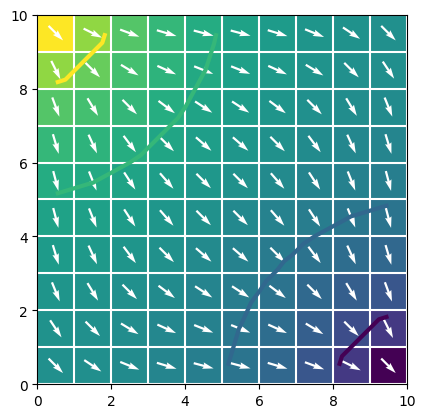

In [49]:
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
pmv.plot_vector(qx, qy, normalize=True, color="white")

/usr/local/lib/python3.9/dist-packages/flopy/plot/crosssection.py:1504: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)
/usr/local/lib/python3.9/dist-packages/flopy/plot/crosssection.py:600: UserWarning: The following kwargs were not used by contour: 'leavels'
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


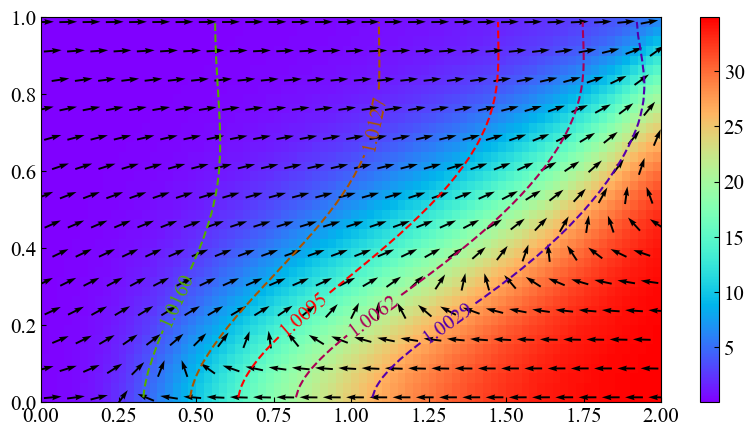

In [51]:
import numpy as np
import matplotlib.pyplot as plt
# filename
sim_ws = 'simulation_test'
sim_name = 'model'
gwfname = "gwf_" + sim_name
gwtname = "gwt_" + sim_name

sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/lib/modflow/mf6')

# units
length_units = "meters"
time_units = "days"

# Discretization
nper = 1
nlay = 40
nrow = 1
ncol = 80
delr = 0.025
delc = 1.0
delv = 0.025
top = 1.0
botm = [top - k * delv for k in range(1, nlay + 1)]
idomain = 1

# GWF
icelltype = 0
k11 = 864.0

# GWT
porosity = 0.35
diffusion_coefficient = 0.57024  # diffusion coefficient

# Temporal discretization
perlen = 0.5
nstp = 500
tsmult = 1.0
tdis_ds = []
tdis_ds.append((perlen, nstp, tsmult))

# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-10, 1e-6, 0.97

# Initial conditions
# Starting heads
strt = 1.0

# Initial concentrations
sconc = 35.0

# Boundary conditions
# wel_spd
inflow = 2.851  # 5.7024
wel_spd = [[(k, 0, 0), inflow / nlay, 0.0] for k in range(nlay)]

# ghb_spd
ghbcond = k11 * delv * delc / (0.5 * delr)
ghb_spd = [[(k, 0, ncol - 1), top, ghbcond, 35.0] for k in range(nlay)]


def build_model(inflow):
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/lib/modflow/mf6')
    flopy.mf6.ModflowTdis(
        sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option="ALL", outer_dvclose=hclose, outer_maximum=nouter,
                                  under_relaxation="NONE", inner_maximum=ninner, inner_dvclose=hclose,
                                  rcloserecord=rclose, linear_acceleration="BICGSTAB", scaling_method="NONE",
                                  reordering_method="NONE", relaxation_factor=relax,
                                  filename="{}.ims".format(gwfname))
    sim.register_ims_package(imsgwf, [gwfname])

    flopy.mf6.ModflowGwfdis(gwf, length_units=length_units, nlay=nlay, nrow=nrow, ncol=ncol,
                            delr=delr, delc=delc, top=top, botm=botm, idomain=idomain)
    flopy.mf6.ModflowGwfnpf(
        gwf, save_specific_discharge=True, icelltype=icelltype, k=k11)
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    buy_pd = [(0, 0.7, 0.0, gwtname, "concentration")]
    flopy.mf6.ModflowGwfbuy(gwf, packagedata=buy_pd)

    flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghb_spd,
                            pname="GHB-1", auxiliary="CONCENTRATION")

    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd,
                            pname="WEL-1", auxiliary="CONCENTRATION")
    flopy.mf6.ModflowGwfoc(gwf, head_filerecord="{}.hds".format(gwfname),
                           budget_filerecord="{}.bud".format(gwfname),
                           saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])

    gwt = flopy.mf6.ModflowGwt(sim, modelname=gwtname)
    imsgwt = flopy.mf6.ModflowIms(sim, print_option="ALL", outer_dvclose=hclose, outer_maximum=nouter,
                                  under_relaxation="NONE", inner_maximum=ninner, inner_dvclose=hclose,
                                  rcloserecord=rclose, linear_acceleration="BICGSTAB",
                                  scaling_method="NONE", reordering_method="NONE",
                                  relaxation_factor=relax, filename="{}.ims".format(gwtname))
    sim.register_ims_package(imsgwt, [gwtname])

    flopy.mf6.ModflowGwtdis(gwt, length_units=length_units, nlay=nlay, nrow=nrow, ncol=ncol,
                            delr=delr, delc=delc, top=top, botm=botm)
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtic(gwt, strt=sconc)
    flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, diffc=diffusion_coefficient)

    sourcerecarray = [("GHB-1", "AUX", "CONCENTRATION"),
                      ("WEL-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    flopy.mf6.ModflowGwtoc(gwt, budget_filerecord="{}.cbc".format(gwtname),
                           concentration_filerecord="{}.ucn".format(gwtname),
                           saverecord=[("CONCENTRATION", "ALL")])
    flopy.mf6.ModflowGwfgwt(sim, exgtype="GWF6-GWT6", exgmnamea=gwfname, exgmnameb=gwtname,
                            filename="{}.gwfgwt".format(sim_name))
    return sim, gwf, gwt

def run_sim(sim):
    sim.write_simulation(silent=True)
    success, buff = sim.run_simulation(silent=True)
    if not success:
        raise Exception("MODFLOW 6 did not terminate normally.")


sim, gwf, gwt = build_model(inflow)
run_sim(sim)

head = gwf.oc.output.head().get_alldata()
concentration = gwt.oc.output.concentration().get_alldata()
# gwt_budget = gwt.oc.output.budget().get_data(kstpkper = (0, 0))
gwf_budget = gwf.oc.output.budget().get_data(kstpkper=(0, 0))


def plot_results(model, a):
    config = {'font.family': 'Times New Roman', 'font.size': 15, 'xtick.direction': 'in', 'ytick.direction': 'in',
              'mathtext.fontset': 'stix', 'savefig.dpi': 300}
    plt.rcParams.update(config)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    pmv = flopy.plot.PlotCrossSection(model=model, ax=ax, line={"row": 0})
    pmv.plot_grid(ax=ax, color=".5", alpha=0.2)

    plot_array = pmv.plot_array(a, cmap='rainbow')
    plt.colorbar(plot_array)

    plot_contour_array = pmv.contour_array(
        head[499], leavels=np.arange(1, 1.03, 0.005), cmap="brg", linestyles="--")
    plt.clabel(plot_contour_array, fmt=r'%.4f')
#     plt.colorbar(plot_contour_array)

#     pmv.plot_bc(package = gwf.get_package("GHB-1"), color = 'green')
#     pmv.plot_bc(package = gwf.get_package("WEL-1"), color = 'black')
#     pmv.plot_inactive(ibound = gwf.modelgrid.idomain, color_noflow = 'black')

    spdis = gwf.oc.output.budget().get_data(text='DATA-SPDIS')[499]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    pmv.plot_vector(
        qx, qy, qz, head=head[499], normalize=True, kstep=3, hstep=3, color="black")


plot_results(model=gwt, a=concentration[499])

# 教程1

In [ ]:

# package import
from pathlib import Path
from tempfile import TemporaryDirectory

import flopy

# temp_dir = TemporaryDirectory()
sim_ws = "tutorial01_mf6"
sim_name = "tutorial01_mf6"

# set up simulation and basic packages
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/lib/modflow/mf6')
flopy.mf6.ModflowTdis(
    sim, nper=10, perioddata=[[365.0, 1, 1.0] for _ in range(10)]
)
flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
flopy.mf6.ModflowGwfdis(gwf, nlay=3, nrow=4, ncol=5)
flopy.mf6.ModflowGwfic(gwf)
flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
flopy.mf6.ModflowGwfchd(
    gwf, stress_period_data=[[(0, 0, 0), 1.0], [(2, 3, 4), 0.0]]
)
budget_file = f"{name}.bud"
head_file = f"{name}.hds"
flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=budget_file,
    head_filerecord=head_file,
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print("Done creating simulation.")

# ## Accessing Simulation-Level Settings
#
# FloPy has a number of settings that can be set for the entire simulation.
# These include how much information FloPy writes to the console, how to
# format the MODFLOW package files, and whether to verify MODFLOW data.

# The verbosity level, which determines how much FloPy writes to command line
# output.  The options are 1 for quiet, 2 for normal, and 3 for verbose.
# Below we set the verbosity level to verbose.

sim.simulation_data.verbosity_level = 3

# We can also set the number of spaces to indent data when writing package
# files by setting the indent string.

sim.simulation_data.indent_string = "    "

# Next we set the precision and number of characters written for floating
# point variables.

sim.float_precision = 8
sim.float_characters = 15

# Lastly, we disable verify_data and auto_set_sizes for faster performance.
# With these options disabled FloPy will not do any checking or autocorrecting
# of your data.

sim.verify_data = False
sim.auto_set_sizes = False

# ## Accessing Models and Packages
#
# At this point a simulation is available in memory.  In this particular case
# the simulation was created directly using Python code; however, the
# simulation might also have been loaded from existing model files using
# the `FloPy.mf6.MFSimulation.load()` function.

# Once a MODFLOW 6 simulation is available in memory, the contents of the
# simulation object can be listed using a simple print command.

print(sim)

# Simulation-level packages, models, and model packages can be shown by
# printing the simulation object.  In this case, you should see the
# all of the contents of simulation and some information about each FloPy
# object that is part of simulation.

# To get the `TDIS` package and print the contents, we can do the following

tdis = sim.tdis
print(tdis)

# To get the Iterative Model Solution (`IMS`) object, we use the following
# syntax

ims = sim.get_package("ims_-1")
print(ims)

# Or because there is only one `IMS` object for this simulation, we can
# access it as

ims = sim.get_package("ims")
print(ims)

# When printing the sim object, there is also a simulation package called
# nam.  This package contains the information that is written to the
# `mfsim.nam` file, which is the primary file that MODFLOW 6 reads when it
# first starts.  The nam package is automatically updated for you by FloPy and
# does not require modification.

nam = sim.get_package("nam")
print(nam)

# To see the models that are contained within the simulation, we can get a
# list of their names as follows

print(sim.model_names)

# `sim.model_names` returns the keys of an ordered dictionary, which isn't very
# useful to us, but we can convert that to a list and then go through that
# list and print information about each model in the simulation.  In this
# case there is only one model, but had there been more models, we would
# see them listed here

model_names = list(sim.model_names)
for mname in model_names:
    print(mname)

# If we want to get a model from a simulation, then we use the `get_model()`
# method of the sim object.  Here we go through all the models in the
# simulation and print the model name and the model type.

model_names = list(sim.model_names)
for mname in model_names:
    m = sim.get_model(mname)
    print(m.name, m.model_type)

# For this simple case here with only one `GWF` model, we can very easily get
# the FloPy representation of the `GWF` model as

gwf = sim.get_model(name)

# Now that we have the `GWF` object, we can print it, and see what's it
# contains.

print(gwf)

# What we see here is the information that we saw when we printed the sim
# object.

# One of the most common operations on a model is to see what packages are in
# it and then get packages of interest.  A list of packages in a model can
# obtained as

package_list = gwf.get_package_list()
print(package_list)

# As you might expect we can access each package in this list with
# gwf.get_package().  Thus, the following syntax can be used to obtain and
# print the contents of the `DIS` Package

dis = gwf.get_package("dis")
print(dis)

# The Python type for this dis package is simply

print(type(dis))

try:
    temp_dir.cleanup()
except PermissionError:
    # can occur on windows: https://docs.python.org/3/library/tempfile.html#tempfile.TemporaryDirectory
    pass

# 教程5

In [ ]:
# package import
import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np

import flopy

# set up where simulation workspace will be stored
temp_dir = TemporaryDirectory()
workspace = temp_dir.name
name = "tutorial05_mf6_data"

# create the flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws=workspace
)

# create the flopy groundwater flow (gwf) model object
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)
# create the flopy iterative model solver (ims) package object
# (both pname and complexity are scalar data)
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="SIMPLE")

# ## Adding MODFLOW Single Integer and String Values
#
# Single integer and string values can be assigned on construction of the
# `MFScalar` data object, and can be assigned or changed after construction.
#
# Below, a `TDIS` package is constructed with the `time_units` and `nper`
# parameters being assigned "DAYS" and "2", respectively.

# create the FloPy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname="tdis",
    time_units="DAYS",
    nper=2,
    perioddata=[(1.0, 1, 1.0), (1.0, 1, 1.0)],
)

# Next, `time_units` is reassigned a value after construction by using `TDIS`'s
# `time_units` attribute.

tdis.time_units = "MONTHS"

# ## Setting MODFLOW Boolean Flags
# Boolean flags can be assigned a True or False value. In the example below
# `nogrb` is assigned a value of True and then changed to false.
#
# For this example, first some values are first defined for the discretization
# package

nlay = 3
h = 50.0
length = 400.0
n = 10
bot = np.linspace(-h / nlay, -h, nlay)
delrow = delcol = length / (n - 1)

# Below the discretization package is created.  The MODFLOW `nogrb` option
# assigned a value of True, switching this option on.

dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nogrb=True,
    nlay=nlay,
    nrow=n,
    ncol=n,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

# The `nogrb` option is then switched off by setting the `DIS` package's
# `nogrb` attribute to False.

dis.nogrb = False

# Boolean flags with an additional optional flag can either be specified by:
#
# 1. Specifying the entire line as it would be displayed in the package file
#    as a string (`xt3doptions="xt3d rhs"`)
# 2. Specifying each flag name in a list (`xt3doptions=["xt3d", "rhs"]`)
#
# To turn off both flags use an empty string (`xt3doptions=""`) or an empty
# list (`xt3doptions=[]`).

# First, an `NPF` package is created.  `xt3doptions` can either be turned on or
# off, and if it is on `rhs` can optionally be turned on.  `xt3doptions` is set
# to the string "xt3d rhs", turning both options on.

# create the node property flow package with xt3doptions as single
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf,
    rewet_record="REWET WETFCT 1.0 IWETIT 1 IHDWET 0",
    pname="npf",
    icelltype=1,
    k=1.0,
    save_flows=True,
    xt3doptions="xt3d rhs",
)

# Next, the `rhs` option is turned off by setting `xt3doptions` to the string
# "xt3d".

npf.xt3doptions = "xt3d"

# Finally, both `xt3d` and `rhs` are turned off by setting `xt3doptions` to an
# empty string.

npf.xt3doptions = ""

# ## Retrieving MODFLOW Scalar Data
#
# MODFLOW scalar data can be retrieved with `get_data`, `repr`/`str`,
# or `get_file_entry`.
#
# | Retrieval Method    | Description           |
# | :---                |    :----              |
# | get_data    | Returns scalar value              |
# | repr/str    | Returns string with a header describing how data is stored (internal, external) with a string representation of the data on the next line          |
# | get_file_entry   | Returns string with the scalar keyword (if any) followed by a space and a string representation of the scalar value (if any).  This is the format used by the MODFLOW-6 package file.  This is the format used by the MODFLOW-6 package file.        |

# The `IMS` package's `complexity` option and the `NPF` package's
# `xt3doptions` are printed below using the different data retrieval methods
# highlighted above.

# First the complexity data is printed using the `get_data` method.

print(ims.complexity.get_data())

# The xt3doptions data can also be printed with `get_data`.

print(npf.xt3doptions.get_data())

# The complexity data is then printed with repr

print(repr(ims.complexity))

# The xt3doptions data is printed with repr

print(str(npf.xt3doptions))

# The complexity data is printed as it would appear in a MODFLOW 6 file using
# the `get_file_entry` method.

print(ims.complexity.get_file_entry())

# The xt3doptions data is printed as it would appear in a MODFLOW 6 file using
# the `get_file_entry` method.

print(npf.xt3doptions.get_file_entry())

try:
    temp_dir.cleanup()
except PermissionError:
    # can occur on windows: https://docs.python.org/3/library/tempfile.html#tempfile.TemporaryDirectory
    pass

simple
[]
{internal}
('simple')

{internal}
([])

  COMPLEXITY  simple

  



# 教程6

In [ ]:
# package import
import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np

import flopy

# set up where simulation workspace will be stored
temp_dir = TemporaryDirectory()
workspace = temp_dir.name
name = "tutorial06_mf6_data"

# create the Flopy simulation and tdis objects
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws=workspace
)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname="tdis",
    time_units="DAYS",
    nper=2,
    perioddata=[(1.0, 1, 1.0), (1.0, 1, 1.0)],
)
# create the Flopy groundwater flow (gwf) model object
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)
# create the flopy iterative model solver (ims) package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="SIMPLE")
# create the discretization package
bot = np.linspace(-50.0 / 3.0, -3.0, 3)
delrow = delcol = 4.0
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nogrb=True,
    nlay=3,
    nrow=10,
    ncol=10,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

# ## Adding MODFLOW Package Data, Connection Data, and Option Lists
#
# MODFLOW Package data, connection data, and option lists are stored by FloPy
# as numpy recarrays.  FloPy does accept numpy recarrays as input, but does
# has other supported formats discussed below.
#
# MODFLOW option lists that only contain a single row or data can be either
# specified by:
#
# 1. Specifying a string containing the entire line as it would be displayed
#    in the package file (`rewet_record="REWET WETFCT 1.0 IWETIT 1 IHDWET 0"`)
# 2. Specifying the data in a tuple within a list
#    (`rewet_record=[("WETFCT", 1.0, "IWETIT", 1, "IHDWET", 0)]`)
#
# In the example below the npf package is created setting the `rewet_record`
# option to a string of text as would be typed into the package file.

npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf,
    rewet_record="REWET WETFCT 1.0 IWETIT 1 IHDWET 0",
    pname="npf",
    icelltype=1,
    k=1.0,
    save_flows=True,
    xt3doptions="xt3d rhs",
)

# `rewet_record` is then set using the npf package's `rewet_record` property.
# This time 'rewet_record' is defined using a tuple within a list.

npf.rewet_record = [("WETFCT", 1.1, "IWETIT", 0, "IHDWET", 1)]

# MODFLOW multirow lists, like package data and connection data, can be
# specified:
#
# 1. As a list of tuples where each tuple represents a row in the list
#   (stress_period_data = [((1, 2, 3), 20.0), ((1, 7, 3), 25.0)])
# 2. As a numpy recarray.  Building a numpy recarray is more complicated and
#    is beyond the scope of this guide.
#
# In the example below the chd package is created, setting `stress_period_data`
# as a list of tuples.

# We build the chd package using an array of tuples for stress_period_data
# stress_period_data = [(first_chd_cell, head), (second_chd_cell, head), ...]
# Note that the cellid information (layer, row, column) is encapsulated in
# a tuple.

stress_period_data = [((1, 10, 10), 100.0), ((1, 10, 11), 105.0)]
# build chd package
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(stress_period_data),
    stress_period_data=stress_period_data,
    save_flows=True,
)

# ## Adding Stress Period List Data
#
# MODFLOW stress period data is stored by FloPy as a dictionary of numpy
# recarrays, where each dictionary key is a zero-based stress period and each
# dictionary value is a recarray containing the stress period data for that
# stress period.  FloPy keeps this stress period data in a `MFTransientList`
# object and this data type is referred to as a transient list.
#
# FloPy accepts stress period data as a dictionary of numpy recarrays, but also
# supports replacing the recarrays with lists of tuples discussed above.
# Stress period data spanning multiple stress periods must be specified as a
# dictionary of lists where the dictionary key is the stress period expressed
# as a zero-based integer.
#
# The example below creates `stress_period_data` for the wel package with the
# first stress period containing a single well and the second stress period
# empty.  When empty stress period data is entered FloPy writes an empty
# stress period block to the package file.

# First we create wel package with stress_period_data dictionary
# keys as zero-based integers so key "0" is stress period 1

stress_period_data = {
    0: [((2, 3, 1), -25.0)],  # stress period 1 well data
    1: [],
}  # stress period 2 well data is empty

# Then, using the dictionary created above, we build the wel package.

wel = flopy.mf6.ModflowGwfwel(
    gwf,
    print_input=True,
    print_flows=True,
    stress_period_data=stress_period_data,
    save_flows=False,
    pname="WEL-1",
)

# ## Retrieving MODFLOW Package Data, Connection Data, and Option Lists
#
# MODFLOW package data, connection data, and option lists can be retrieved
# with `get_data`, `array`, `repr`/`str`,
# or get_file_entry.
#
# | Retrieval Method    | Description           |
# | :---                |    :----              |
# | get_data    | Returns recarray              |
# | array       | Return recarray               |
# | repr/str    | Returns string with storage information followed by recarray's repr/str           |
# | get_file_entry   | Returns string containing data formatted for the MODFLOW-6 package file. Certain zero-based numbers, like layer, row, column, are converted to one-based numbers.           |

# The `NPF` package's `rewet_record` is printed below using the different data
# retrieval methods highlighted above.

# First we use the `get_data` method to get the rewet_record as a recarray.

print(npf.rewet_record.get_data())

# Next we use the `array` method, which also returns a recarray.

print(npf.rewet_record.array)

# Then we use repr to print a string representation of rewet_record.

print(repr(npf.rewet_record))

# Using str prints a similar string representation of rewet_record.

print(str(npf.rewet_record))

# Last, using the `get_file_entry` method the data is printed as it would
# appear in a MODFLOW 6 file.

print(npf.rewet_record.get_file_entry())

# ## Retrieving MODFLOW Stress Period List Data
# Stress period data can be retrieved with `get_data`, `array`, `repr`/`str`,
# or `get_file_entry`.
#
# | Retrieval Method    | Description           |
# | :---                |    :----              |
# | get_data    | Returns dictionary of recarrays              |
# | array       | Return single recarray for all stress periods               |
# | repr/str    | Returns string with storage information followed by recarray repr/str for each recarray          |
# | get_file_entry(key)   | Returns string containing data formatted for the MODFLOW-6 package file for the stress period specified by key         |

# The `WEL` package's `stress_period_data` is printed below using the
# different data retrieval methods highlighted above.

# First we use the `get_data` method to get the stress period data as a
# dictionary of recarrays.

print(wel.stress_period_data.get_data())

# Next we use the `array` attribute to get the stress period data as a single
# recarray.

print(wel.stress_period_data.array)

# repr can be used to generate a string representation of stress period data.

print(repr(wel.stress_period_data))

# str produces a similar string representation of stress period data.

print(str(wel.stress_period_data))

# The `get_file_entry` method prints the stress period data as it would
# appear in a MODFLOW 6 file.

print(wel.stress_period_data.get_file_entry(0))

try:
    temp_dir.cleanup()
except PermissionError:
    # can occur on windows: https://docs.python.org/3/library/tempfile.html#tempfile.TemporaryDirectory
    pass

[('WETFCT', 1.1, 'IWETIT', 0, 'IHDWET', 1)]
[('WETFCT', 1.1, 'IWETIT', 0, 'IHDWET', 1)]
{internal}
(rec.array([('WETFCT', 1.1, 'IWETIT', 0, 'IHDWET', 1)],
          dtype=[('wetfct_label', 'O'), ('wetfct', '<f8'), ('iwetit_label', 'O'), ('iwetit', '<i8'), ('ihdwet_label', 'O'), ('ihdwet', '<i8')]))

{internal}
([('WETFCT', 1.1, 'IWETIT', 0, 'IHDWET', 1)])

  REWET  WETFCT       1.10000000  IWETIT  0  IHDWET  1

{0: rec.array([((2, 3, 1), -25.)],
          dtype=[('cellid', 'O'), ('q', '<f8')])}
[rec.array([((2, 3, 1), -25.)],
          dtype=[('cellid', 'O'), ('q', '<f8')]), None]
{internal}
(rec.array([((2, 3, 1), -25.)],
          dtype=[('cellid', 'O'), ('q', '<f8')]))

{internal}
([((2, 3, 1), -25.)])

  3 4 2     -25.00000000



In [ ]:
!pwd

/content


# mt3d

In [ ]:
!pip install flaky

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import warnings

import numpy as np
import pytest
# from autotest.conftest import excludes_platform, requires_exe
import flaky

In [ ]:
from flopy.modflow import (
    Modflow,
    ModflowBas,
    ModflowDis,
    ModflowEvt,
    ModflowGhb,
    ModflowLak,
    ModflowLmt,
    ModflowLpf,
    ModflowNwt,
    ModflowOc,
    ModflowPcg,
    ModflowRch,
    ModflowUpw,
    ModflowWel,
)
from flopy.mt3d import (
    Mt3dAdv,
    Mt3dBtn,
    Mt3dDsp,
    Mt3dGcg,
    Mt3dLkt,
    Mt3dms,
    Mt3dPhc,
    Mt3dRct,
    Mt3dSsm,
    Mt3dTob,
)


# autotest

https://github.com/modflowpy/flopy/blob/7973c70f523706da87c591de87680620e28ab293/autotest/test_seawat.py

In [ ]:
import importlib
import os
import socket
import sys
from os import environ
from os.path import basename, normpath
from pathlib import Path
from platform import system
from shutil import copytree, which
from subprocess import PIPE, Popen
from typing import List, Optional
from urllib import request
from warnings import warn

import matplotlib.pyplot as plt
import pkg_resources
import pytest

# constants

SHAPEFILE_EXTENSIONS = ["prj", "shx", "dbf"]
__file__ = '/usr/local/modflow/modflow'

# misc utilities


def get_project_root_path() -> Path:
    return Path(__file__).parent.parent


def get_example_data_path() -> Path:
    return get_project_root_path() / "examples" / "data"


def get_flopy_data_path() -> Path:
    return get_project_root_path() / "flopy" / "data"


def get_current_branch() -> str:
    # check if on GitHub Actions CI
    ref = environ.get("GITHUB_REF")
    if ref is not None:
        return basename(normpath(ref)).lower()

    # otherwise ask git about it
    if not which("git"):
        raise RuntimeError("'git' required to determine current branch")
    stdout, stderr, code = run_cmd("git", "rev-parse", "--abbrev-ref", "HEAD")
    if code == 0 and stdout:
        return stdout.strip().lower()
    raise ValueError(f"Could not determine current branch: {stderr}")


def is_connected(hostname):
    """See https://stackoverflow.com/a/20913928/ to test hostname."""
    try:
        host = socket.gethostbyname(hostname)
        s = socket.create_connection((host, 80), 2)
        s.close()
        return True
    except Exception:
        pass
    return False


def is_in_ci():
    # if running in GitHub Actions CI, "CI" variable always set to true
    # https://docs.github.com/en/actions/learn-github-actions/environment-variables#default-environment-variables
    return bool(os.environ.get("CI", None))


def is_github_rate_limited() -> Optional[bool]:
    """
    Determines if a GitHub API rate limit is applied to the current IP.
    Note that running this function will consume an API request!
    Returns
    -------
        True if rate-limiting is applied, otherwise False (or None if the connection fails).
    """
    try:
        with request.urlopen(
            "https://api.github.com/users/octocat"
        ) as response:
            remaining = int(response.headers["x-ratelimit-remaining"])
            if remaining < 10:
                warn(
                    f"Only {remaining} GitHub API requests remaining before rate-limiting"
                )
            return remaining > 0
    except:
        return None


_has_exe_cache = {}
_has_pkg_cache = {}


def has_exe(exe):
    if exe not in _has_exe_cache:
        _has_exe_cache[exe] = bool(which(exe))
    return _has_exe_cache[exe]


def has_pkg(pkg):
    if pkg not in _has_pkg_cache:

        # for some dependencies, package name and import name are different
        # (e.g. pyshp/shapefile, mfpymake/pymake, python-dateutil/dateutil)
        # pkg_resources expects package name, importlib expects import name
        try:
            _has_pkg_cache[pkg] = bool(importlib.import_module(pkg))
        except (ImportError, ModuleNotFoundError):
            try:
                _has_pkg_cache[pkg] = bool(pkg_resources.get_distribution(pkg))
            except pkg_resources.DistributionNotFound:
                _has_pkg_cache[pkg] = False

    return _has_pkg_cache[pkg]


def requires_exe(*exes):
    missing = {exe for exe in exes if not has_exe(exe)}
    return pytest.mark.skipif(
        missing,
        reason=f"missing executable{'s' if len(missing) != 1 else ''}: "
        + ", ".join(missing),
    )


def requires_pkg(*pkgs):
    missing = {pkg for pkg in pkgs if not has_pkg(pkg)}
    return pytest.mark.skipif(
        missing,
        reason=f"missing package{'s' if len(missing) != 1 else ''}: "
        + ", ".join(missing),
    )


def requires_platform(platform, ci_only=False):
    return pytest.mark.skipif(
        system().lower() != platform.lower()
        and (is_in_ci() if ci_only else True),
        reason=f"only compatible with platform: {platform.lower()}",
    )


def excludes_platform(platform, ci_only=False):
    return pytest.mark.skipif(
        system().lower() == platform.lower()
        and (is_in_ci() if ci_only else True),
        reason=f"not compatible with platform: {platform.lower()}",
    )


def requires_branch(branch):
    current = get_current_branch()
    return pytest.mark.skipif(
        current != branch, reason=f"must run on branch: {branch}"
    )


def excludes_branch(branch):
    current = get_current_branch()
    return pytest.mark.skipif(
        current == branch, reason=f"can't run on branch: {branch}"
    )


requires_github = pytest.mark.skipif(
    not is_connected("github.com"), reason="github.com is required."
)


requires_spatial_reference = pytest.mark.skipif(
    not is_connected("spatialreference.org"),
    reason="spatialreference.org is required.",
)


# example data fixtures


@pytest.fixture(scope="session")
def project_root_path() -> Path:
    return get_project_root_path()


@pytest.fixture(scope="session")
def example_data_path() -> Path:
    return get_example_data_path()


@pytest.fixture(scope="session")
def flopy_data_path() -> Path:
    return get_flopy_data_path()


@pytest.fixture(scope="session")
def example_shapefiles(example_data_path) -> List[Path]:
    return [f.resolve() for f in (example_data_path / "prj_test").glob("*")]


# keepable temporary directory fixtures for various scopes


@pytest.fixture(scope="function")
def tmpdir(tmpdir_factory, request) -> Path:
    node = (
        request.node.name.replace("/", "_")
        .replace("\\", "_")
        .replace(":", "_")
    )
    temp = Path(tmpdir_factory.mktemp(node))
    yield Path(temp)

    keep = request.config.getoption("--keep")
    if keep:
        copytree(temp, Path(keep) / temp.name)

    keep_failed = request.config.getoption("--keep-failed")
    if keep_failed and request.node.rep_call.failed:
        copytree(temp, Path(keep_failed) / temp.name)


@pytest.fixture(scope="class")
def class_tmpdir(tmpdir_factory, request) -> Path:
    assert (
        request.cls is not None
    ), "Class-scoped temp dir fixture must be used on class"
    temp = Path(tmpdir_factory.mktemp(request.cls.__name__))
    yield temp

    keep = request.config.getoption("--keep")
    if keep:
        copytree(temp, Path(keep) / temp.name)


@pytest.fixture(scope="module")
def module_tmpdir(tmpdir_factory, request) -> Path:
    temp = Path(tmpdir_factory.mktemp(request.module.__name__))
    yield temp

    keep = request.config.getoption("--keep")
    if keep:
        copytree(temp, Path(keep) / temp.name)


@pytest.fixture(scope="session")
def session_tmpdir(tmpdir_factory, request) -> Path:
    temp = Path(tmpdir_factory.mktemp(request.session.name))
    yield temp

    keep = request.config.getoption("--keep")
    if keep:
        copytree(temp, Path(keep) / temp.name)


# fixture to automatically close any plots (or optionally show them)


@pytest.fixture(autouse=True)
def close_plot(request):
    yield

    # plots only shown if requested via CLI flag,
    # figures are available, and we're not in CI
    show = request.config.getoption("--show-plots")
    if len(plt.get_fignums()) > 0 and not is_in_ci() and show:
        plt.show()
    else:
        plt.close("all")


# pytest configuration hooks


@pytest.hookimpl(hookwrapper=True, tryfirst=True)
def pytest_runtest_makereport(item, call):
    # this is necessary so temp dir fixtures can
    # inspect test results and check for failure
    # (see https://doc.pytest.org/en/latest/example/simple.html#making-test-result-information-available-in-fixtures)

    outcome = yield
    rep = outcome.get_result()

    # report attribute for each phase (setup, call, teardown)
    # we're only interested in result of the function call
    setattr(item, "rep_" + rep.when, rep)


def pytest_addoption(parser):
    parser.addoption(
        "-K",
        "--keep",
        action="store",
        default=None,
        help="Move the contents of temporary test directories to correspondingly named subdirectories at the given "
        "location after tests complete. This option can be used to exclude test results from automatic cleanup, "
        "e.g. for manual inspection. The provided path is created if it does not already exist. An error is "
        "thrown if any matching files already exist.",
    )

    parser.addoption(
        "--keep-failed",
        action="store",
        default=None,
        help="Move the contents of temporary test directories to correspondingly named subdirectories at the given "
        "location if the test case fails. This option automatically saves the outputs of failed tests in the "
        "given location. The path is created if it doesn't already exist. An error is thrown if files with the "
        "same names already exist in the given location.",
    )

    parser.addoption(
        "-M",
        "--meta",
        action="store",
        metavar="NAME",
        help="Marker indicating a test is only run by other tests (e.g., the test framework testing itself).",
    )

    parser.addoption(
        "-S",
        "--smoke",
        action="store_true",
        default=False,
        help="Run only smoke tests (should complete in <1 minute).",
    )

    parser.addoption(
        "--show-plots",
        action="store_true",
        default=False,
        help="Show any figure windows created by test cases. (Useful to display plots for visual inspection, "
        "but automated tests should probably also check patch collections or figure & axis properties.)",
    )


def pytest_configure(config):
    config.addinivalue_line(
        "markers",
        "meta(name): mark test to run only inside other groups of tests.",
    )


def pytest_runtest_setup(item):
    # apply meta-test option
    meta = item.config.getoption("--meta")
    metagroups = [mark.args[0] for mark in item.iter_markers(name="meta")]
    if metagroups and meta not in metagroups:
        pytest.skip()

    # smoke tests are \ {slow U example U regression}
    smoke = item.config.getoption("--smoke")
    slow = list(item.iter_markers(name="slow"))
    example = list(item.iter_markers(name="example"))
    regression = list(item.iter_markers(name="regression"))
    if smoke and (slow or example or regression):
        pytest.skip()


def pytest_report_header(config):
    """Header for pytest to show versions of packages."""

    # if we ever drop support for python 3.7, could use importlib.metadata instead?
    # or importlib_metadata backport: https://importlib-metadata.readthedocs.io/en/latest/
    # pkg_resources discouraged: https://setuptools.pypa.io/en/latest/pkg_resources.html

    processed = set()
    flopy_pkg = pkg_resources.get_distribution("flopy")
    lines = []
    items = []
    for pkg in flopy_pkg.requires():
        name = pkg.name
        processed.add(name)
        try:
            version = pkg_resources.get_distribution(name).version
            items.append(f"{name}-{version}")
        except pkg_resources.DistributionNotFound:
            items.append(f"{name} (not found)")
    lines.append("required packages: " + ", ".join(items))
    installed = []
    not_found = []
    for pkg in flopy_pkg.requires(["optional"]):
        name = pkg.name
        if name in processed:
            continue
        processed.add(name)
        try:
            version = pkg_resources.get_distribution(name).version
            installed.append(f"{name}-{version}")
        except pkg_resources.DistributionNotFound:
            not_found.append(name)
    if installed:
        lines.append("optional packages: " + ", ".join(installed))
    if not_found:
        lines.append("optional packages not found: " + ", ".join(not_found))
    return "\n".join(lines)


# functions to run commands and scripts


def run_cmd(*args, verbose=False, **kwargs):
    """Run any command, return tuple (stdout, stderr, returncode)."""
    args = [str(g) for g in args]
    if verbose:
        print("running: " + " ".join(args))
    p = Popen(args, stdout=PIPE, stderr=PIPE, **kwargs)
    stdout, stderr = p.communicate()
    stdout = stdout.decode()
    stderr = stderr.decode()
    returncode = p.returncode
    if verbose:
        print(f"stdout:\n{stdout}")
        print(f"stderr:\n{stderr}")
        print(f"returncode: {returncode}")
    return stdout, stderr, returncode


def run_py_script(script, *args, verbose=False):
    """Run a Python script, return tuple (stdout, stderr, returncode)."""
    return run_cmd(
        sys.executable, script, *args, verbose=verbose, cwd=Path(script).parent
    )


# use noninteractive matplotlib backend if in Mac OS CI to avoid pytest-xdist node failure
# e.g. https://github.com/modflowpy/flopy/runs/7748574375?check_suite_focus=true#step:9:57
@pytest.fixture(scope="session", autouse=True)
def patch_macos_ci_matplotlib():
    if is_in_ci() and system().lower() == "darwin":
        import matplotlib

        matplotlib.use("agg")

# case1


In [ ]:
nlay, nrow, ncol = 10, 10, 10
perlen = np.zeros((10), dtype=float) + 10
nper = len(perlen)

ibound = np.ones((nlay, nrow, ncol), dtype=int)

botm = np.arange(-1, -11, -1)
top = 0.0

In [ ]:
# temporary directory
# temp_dir = "/content"
# temp_dir = TemporaryDirectory()
# model_ws = temp_dir.name

modelname = "ssmex"
mf = flopy.modflow.Modflow(modelname, exe_name= '/usr/local/modflow/mf2005', model_ws = './ssmex')
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    perlen=perlen,
    nper=nper,
    botm=botm,
    top=top,
    steady=False,
)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=top)
lpf = flopy.modflow.ModflowLpf(mf, hk=100, vka=100, ss=0.00001, sy=0.1)
oc = flopy.modflow.ModflowOc(mf)
pcg = flopy.modflow.ModflowPcg(mf)
rch = flopy.modflow.ModflowRch(mf)

我们将使用MODFLOW边界条件跟踪SSM数据的单元格位置。

获取一个字典（dict），其中包含每个边界类型的SSM ittype。

In [ ]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
print(itype)
print(flopy.mt3d.Mt3dSsm.get_default_dtype())
ssm_data = {}

{'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}
[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('css', '<f4'), ('itype', '<i8')]


添加常规头部边界（ghb）。在前5个应力阶段，一般封头边界封头（bhead）为0.1，组分1（comp_1）浓度为1.0，组分2（comp_2）浓度为100.0。然后，bhead增加到0.25，comp_1浓度减少到0.5，comp_2浓度增加到200.0

In [ ]:
ghb_data = {}
print(flopy.modflow.ModflowGhb.get_default_dtype())
ghb_data[0] = [(4, 4, 4, 0.1, 1.5)]
ssm_data[0] = [(4, 4, 4, 1.0, itype["GHB"], 1.0, 100.0)]
ghb_data[5] = [(4, 4, 4, 0.25, 1.5)]
ssm_data[5] = [(4, 4, 4, 0.5, itype["GHB"], 0.5, 200.0)]

for k in range(nlay):
    for i in range(nrow):
        ghb_data[0].append((k, i, 0, 0.0, 100.0))
        ssm_data[0].append((k, i, 0, 0.0, itype["GHB"], 0.0, 0.0))

ghb_data[5] = [(4, 4, 4, 0.25, 1.5)]
ssm_data[5] = [(4, 4, 4, 0.5, itype["GHB"], 0.5, 200.0)]
for k in range(nlay):
    for i in range(nrow):
        ghb_data[5].append((k, i, 0, -0.5, 100.0))
        ssm_data[5].append((k, i, 0, 0.0, itype["GHB"], 0.0, 0.0))


[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('bhead', '<f4'), ('cond', '<f4')]


添加注入井。在所有应力阶段，注入速率（通量）为10.0，comp_1浓度为10.0且comp_2浓度为0.0。警告：由于我们在压力期6更改了SSM数据，因此需要将井添加到压力期6的SSM_data中。

In [ ]:
wel_data = {}
print(flopy.modflow.ModflowWel.get_default_dtype())
wel_data[0] = [(0, 4, 8, 10.0)]
ssm_data[0].append((0, 4, 8, 10.0, itype["WEL"], 10.0, 0.0))
ssm_data[5].append((0, 4, 8, 10.0, itype["WEL"], 10.0, 0.0))

[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('flux', '<f4')]


In [ ]:
# 将GHB和WEL包添加到mf MODFLOW对象实例。
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=ghb_data)
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_data)

Create the MT3DMS packages

In [ ]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, model_ws=model_ws)
btn = flopy.mt3d.Mt3dBtn(mt, sconc=0, ncomp=2, sconc2=50.0)
adv = flopy.mt3d.Mt3dAdv(mt)
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)
gcg = flopy.mt3d.Mt3dGcg(mt)

found 'rch' in modflow model, resetting crch to 0.0
SSM: setting crch for component 2 to zero. kwarg name crch2


In [ ]:
# 让我们验证stress_period_data是否具有正确的数据类型
print(ssm.stress_period_data.dtype)

[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('css', '<f4'), ('itype', '<i8'), ('cssm(01)', '<f4'), ('cssm(02)', '<f4')]


Create the SEAWAT packages

In [ ]:
swt = flopy.seawat.Seawat(
    modflowmodel=mf,
    mt3dmodel=mt,
    modelname=modelname,
    namefile_ext="nam_swt",
    model_ws=model_ws,
)
vdf = flopy.seawat.SeawatVdf(swt, mtdnconc=0, iwtable=0, indense=-1)

In [ ]:
mf.write_input()
mt.write_input()
swt.write_input()

最后，修改vdf包以修复indense。

In [ ]:
fname = modelname + ".vdf"
f = open(os.path.join(model_ws, fname), "r")
lines = f.readlines()
f.close()
f = open(os.path.join(model_ws, fname), "w")
for line in lines:
    f.write(line)
for kper in range(nper):
    f.write("-1\n")
f.close()

In [ ]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass